In [1]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import time
import random
import matplotlib.pyplot as plt
import heapq
from mpl_toolkits.mplot3d import Axes3D

In [2]:
tf.VERSION

'1.12.0'

In [3]:
%matplotlib inline

## Finite Element Model of the Space Frame Element

In [4]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [5]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [6]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [7]:
def FEA_u(coord, elcon, bc_u_elim, f_after_u_elim, E=210e6,G=84e6,A=2e-2,Iy=10e-5,Iz=20e-5,J=5e-5):
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
    K=np.delete(K,bc_u_elim,0)
    K=np.delete(K,bc_u_elim,1)    
    d=np.dot(np.linalg.inv(K),f_after_u_elim)        
    u=np.zeros(shape=(6*len(coord)))

    j=0
    for i in range(len(u)):
        if i not in bc_u_elim:
            u[i]=d[j]
            j+=1
            if j>len(d)-1:
                break
    return u

## Utils

In [8]:
def total_length(coord,elcon):
    t_length=0
    for i in range(len(elcon)):
        l=PlaneTrussElementLength(coord[elcon[i][0]][0],\
                                    coord[elcon[i][0]][1],\
                                    coord[elcon[i][0]][2],\
                                    coord[elcon[i][1]][0],\
                                    coord[elcon[i][1]][1],\
                                    coord[elcon[i][1]][2])
        t_length+=l        
    return t_length    

In [9]:
def pad(l, content, width):
    l.extend([content] * (width - len(l)))
    return l

In [10]:
def triangle(elcon):
    c=random.randint(0,np.max(elcon))

    T=[]
    for i in range(len(elcon)):
        if np.any(np.not_equal(elcon[i],elcon[c])) and elcon[c][1] in elcon[i]:
            T+=list(elcon[i])  
            
    T=set(T)
    T=list(T)
    
    for j in range(len(T)):
        if ([elcon[c][0],T[j]] in elcon.tolist() or [T[j],elcon[c][0]] in elcon.tolist()) \
                        and  np.any(np.not_equal(np.array([elcon[c][0],T[j]]),elcon[c])):
            return [elcon[c][0],elcon[c][1],T[j]]

In [11]:
def mid_point_triangle(tr_edges,coord):
    ox=(coord[tr_edges[0]][0]+coord[tr_edges[1]][0]+coord[tr_edges[2]][0])/3
    oy=(coord[tr_edges[0]][1]+coord[tr_edges[1]][1]+coord[tr_edges[2]][1])/3
    oz=0
    return list((ox,oy,oz))

In [12]:
def new_connections(tr_edges,coord):  
    K=tr_edges    
    return [[len(coord),K[0]],[len(coord),K[1]],[len(coord),K[2]]]

## Geometry

In [13]:
class Geometry:
    def __init__(self,coord,elcon,bc_u_elim,f_after_u_elim,\
                 E=210e6,G=84e6,A=2e-2,Iy=10e-5,Iz=20e-5,J=5e-5,flag=False,position=5):
        self.coord=coord.reshape(len(coord)//3,3)
        self.elcon=elcon
        self.bc_u_elim=bc_u_elim
        self.f_after_u_elim=f_after_u_elim
        self.E=E
        self.G=G
        self.A=A
        self.Iy=Iy
        self.Iz=Iz
        self.J=J
        self.flag=flag
        self.position=position
        
    def reset(self, coord,elcon,bc_u_elim,f_after_u_elim,\
                 E=210e6,G=84e6,A=2e-2,Iy=10e-5,Iz=20e-5,J=5e-5,flag=False,position=5):    
        self.coord=coord.reshape(len(coord)//3,3)
        self.elcon=elcon
        self.bc_u_elim=bc_u_elim
        self.f_after_u_elim=f_after_u_elim
        self.E=E
        self.G=G
        self.A=A
        self.Iy=Iy
        self.Iz=Iz
        self.J=J
        self.flag=flag
        self.position=position
        
        
    def FEA(self):
        return FEA_u(self.coord, self.elcon, self.bc_u_elim, self.f_after_u_elim,
                     self.E,self.G,self.A,self.Iy,self.Iz,self.J)
    
    def length(self):
        return total_length(self.coord,self.elcon)
    
    def add_node(self):
        tr_edges=triangle(self.elcon)
        new_coord=mid_point_triangle(tr_edges,self.coord)
        nc=new_connections(tr_edges,self.coord)
        self.elcon=np.vstack((self.elcon, nc))
        self.coord=np.vstack((self.coord, new_coord))
        self.position=np.max(self.elcon)
        self.bc_u_elim=self.bc_u_elim+list(range(max(self.bc_u_elim)+1,max(self.bc_u_elim)+6+1))
        if len(self.coord//3)>=15:
            self.flag=True    
            
    def del_node(self):
        for i in range(3):
            self.elcon=np.delete(self.elcon,(-1), axis=0)
            
        self.coord= np.delete(self.coord,(-1), axis=0) 
        
        for i in range(6):
            self.bc_u_elim.pop()
        
        if len(self.coord//3)<=6:
            self.flag=True
            
    def node_up(self):
        c=self.position
        self.coord[c][1]+=0.2
        if self.coord[c][1]>self.coord[1][1]-0.3:
            self.flag=True
    
    def node_down(self):
        c=self.position
        self.coord[c][1]-=0.2
        if self.coord[c][1]<self.coord[0][1]+0.3:
            self.flag=True
            
    def node_left(self):
        c=self.position
        self.coord[c][0]-=0.2       
        if self.coord[c][0]<self.coord[0][0]+0.3:
            self.flag=True
           
    def node_right(self):
        c=self.position
        self.coord[c][0]+=0.2    
        if self.coord[c][0]>self.coord[2][0]-0.3:
            self.flag=True
            
    def nn_input(self):
        A=pad(list(self.coord.flatten()),0,45)
        A.append(self.position)
        A.append(self.length())
        A.append(self.FEA()[25])
        return A
    
    def action_space(self,action):
        if action==0:
            self.add_node()
        elif action==1:    
            self.del_node()
        elif action==2:  
            self.node_up()
        elif action==3:
            self.node_down()
        elif action==4:
            self.node_left()
        elif action==5:
            self.node_right()
        
    def draw(self,color):
        coord=self.coord.reshape(np.max(self.elcon)+1,3)
        fig=plt.figure(figsize=(13,5))
        for item in self.elcon:
            ax = fig.gca(projection='3d') 
            ax.plot([coord[item[0]][0],coord[item[1]][0]],\
                     [coord[item[0]][1],coord[item[1]][1]],\
                     [coord[item[0]][2],coord[item[1]][2]],
                     color=color) 
            ax.view_init(70,300) 
        plt.show()    

## Neural Network Policy - Policy Gradients

In [14]:
n_inputs = 48 
n_hidden = 100 
n_outputs = 6 
initializer = tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.001

# Build the neural network
X_ = tf.placeholder(tf.float64, shape=[None, n_inputs], name="X_")
hidden = fully_connected(X_, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
hidden1 = fully_connected(hidden, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
# hidden2 = fully_connected(hidden1, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
logits = fully_connected(hidden1, n_outputs, activation_fn=None, weights_initializer=initializer)
outputs = tf.nn.softmax(logits, name="Y_proba")

# Select a random action based on the estimated probabilities
action = tf.random.multinomial(tf.log(outputs), num_samples=1,output_dtype=tf.int64)


y=tf.reshape(tf.one_hot(action,depth=6,dtype=tf.float64),[6,1])
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=tf.transpose(logits))

optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(xentropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float64, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
def discount_rewards(rewards, discount_rate=0.97):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

In [16]:
def discount_and_normalize_rewards(all_rewards, discount_rate=0.97):
    all_discounted_rewards = [discount_rewards(rewards) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [17]:
# this function must be tailored to different FE models


# def const(obs_,obs):
#     a = (abs(obs_[-1]) - abs(obs[-1]))/abs(obs_[-1]) 
#     b = (abs(obs_[-2]) - abs(obs[-2]))/abs(obs_[-2])
#     return a,b, a/b

def reward_(obs_,obs): 
#     if  abs(obs_[-1]) < abs(obs[-1]) and 1.2*abs(obs_[-2])<abs(obs[-2]):
#         return -0.1
#     elif abs(obs_[-1])>abs(obs[-1]) and 1.2*abs(obs_[-2])<abs(obs[-2]):
#         return 0.5
#     elif abs(obs_[-1])>abs(obs[-1]) and 1.2*abs(obs_[-2])>abs(obs[-2]):
#         return 1
#     elif abs(obs_[-1]) < abs(obs[-1]):
#         return -0.5
#     else:
#         return 0

#     if abs(obs_[-1])>abs(obs[-1]) and abs(obs_[-2])>abs(obs[-2]):
#         return 2
#     elif abs(obs_[-1])>abs(obs[-1]):
#         return 3
#     elif abs(obs_[-2])>abs(obs[-2]):
#         return 1
#     else:
#         return 0
    
    if abs(obs_[-1])>abs(obs[-1]):
        return 1
#     elif abs(obs_[-2])>abs(obs[-2]):
#         return 1
#     elif abs(obs_[-1])<abs(obs[-1]):
#         return -100
    else:
        return 0

#     if abs(obs_[-1]) >abs(obs[-1]):
#         return 1
#     elif abs(obs_[-2]) >abs(obs[-2]):
#         return 1
#     else:
#         return 0
#     a = (abs(obs_[-1]) - abs(obs[-1]))/abs(obs_[-1]) 
#     b = (abs(obs_[-2]) - abs(obs[-2]))/abs(obs_[-2])
# #     C=2.8
# #     C=random.choice([2.0,  2.8])
# #     return a+C*b
# #     return (2*C*a*b)/(a+C*b)
#     return (2*a*b)/(a+b)

In [18]:
coord=np.array([0,0,0,0,7,0,7,7,0,7,0,0,3.5,3.5,0,4,4,0,3,4,0])
elcon=np.array([[0,1],[1,2],[2,3],[0,3],[1,6],[2,6],[2,5],[4,5],[4,6],[0,4],[3,4],[3,5],[5,6],[0,6]])
bc_u_elim=list(range(30,42))
f_after_u_elim=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-500,0,0,0,0]

In [19]:
G=Geometry(coord,elcon,bc_u_elim,f_after_u_elim)

In [20]:
n_iterations = 251 #251 # number of training iterations
n_max_steps = 500 # max steps per episode
n_games_per_update = 10 # train the policy every 10 episodes
save_iterations = 10 # save the model every 10 training iterations


with tf.Session() as sess:
    start=time.time()
    init.run() 
    
#     saver.restore(sess, tf.train.latest_checkpoint("./policy10/"))    
#     tf.get_default_graph()
    
    for iteration in range(n_iterations):
               
        all_rewards = [] # all sequences of raw rewards for each episode
        all_gradients = [] # gradients saved at each step of each episode
        
        
        for game in range(n_games_per_update):
            tf.random.set_random_seed(game)
#             init.run() # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            current_rewards = [] # all raw rewards from the current episode
            current_gradients = [] # all gradients from the current episode
    
            G.reset(np.array([0,0,0,0,7,0,7,7,0,7,0,0,3.5,3.5,0,4,4,0,3,4,0]),\
            np.array([[0,1],[1,2],[2,3],[0,3],[1,6],[2,6],[2,5],[4,5],[4,6],[0,4],[3,4],[3,5],[5,6],[0,6]]),\
            list(range(30,42)),[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-500,0,0,0,0])
   
            
            G.position = random.randint(5,np.max(G.elcon))
            obs=G.nn_input()
    
            
            for step in range(n_max_steps):
                
                action_val, gradients_val = sess.run([action, gradients],
                                                     feed_dict={X_: np.array(obs).reshape(1,n_inputs)}) 
                obs_=obs 
                              
                G.action_space(action_val[0][0])
                
                if G.flag:
                    break
                
#                 print(action_val[0][0]) 
                obs=G.nn_input()
                reward=reward_(obs_,obs)
                
                if action_val[0][0]!=0:
                    G.position = random.randint(5,np.max(G.elcon))
                
                current_rewards.append(reward)
                current_gradients.append(gradients_val)

            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

    
            
        # At this point we have run the policy for 10 episodes, and we are
        # ready for a policy update using the algorithm described earlier.
        all_rewards = discount_and_normalize_rewards(all_rewards)
        
        
        
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index] 
                                      for game_index, rewards in enumerate(all_rewards)
                                      for step, reward in enumerate(rewards)],axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        
        
        sess.run(training_op, feed_dict=feed_dict)
        
        if iteration % save_iterations == 0:
#             print("Saving {} iteration".format(iteration))
            print('Time taken for {} epoch {} sec\n'.format(iteration, time.time() - start))
            saver.save(sess, "./policy11/bionic11.ckpt")

# end=time.time()

Time taken for 0 epoch 3.8898367881774902 sec

Time taken for 10 epoch 17.266660928726196 sec

Time taken for 20 epoch 30.587703704833984 sec

Time taken for 30 epoch 45.2676899433136 sec

Time taken for 40 epoch 59.18368101119995 sec

Time taken for 50 epoch 75.5390317440033 sec

Time taken for 60 epoch 89.63656401634216 sec

Time taken for 70 epoch 104.24236965179443 sec

Time taken for 80 epoch 119.68794178962708 sec

Time taken for 90 epoch 134.438325881958 sec

Time taken for 100 epoch 153.65546584129333 sec

Time taken for 110 epoch 169.960844039917 sec

Time taken for 120 epoch 184.08672785758972 sec

Time taken for 130 epoch 198.81799602508545 sec

Time taken for 140 epoch 266.2351429462433 sec

Time taken for 150 epoch 310.0831458568573 sec

Time taken for 160 epoch 357.42353987693787 sec

Time taken for 170 epoch 434.98671889305115 sec

Time taken for 180 epoch 454.16703176498413 sec

Time taken for 190 epoch 485.1989288330078 sec

Time taken for 200 epoch 517.955080986023 se

## AI designing the bionic partition

In [21]:
def predict(G2):
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('./policy11/bionic11.ckpt.meta')
        saver.restore(sess, "./policy11/bionic11.ckpt") 

        graph = tf.get_default_graph()
        outputs = graph.get_tensor_by_name("Y_proba:0") 
        X_ = graph.get_tensor_by_name("X_:0") 
                
        G2.reset(np.array([0,0,0,0,7,0,7,7,0,7,0,0,3.5,3.5,0,4,4,0,3,4,0]),\
        np.array([[0,1],[1,2],[2,3],[0,3],[1,6],[2,6],[2,5],[4,5],[4,6],[0,4],[3,4],[3,5],[5,6],[0,6]]),\
        list(range(30,42)),[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-500,0,0,0,0])    
    
        G2.position = random.randint(5,np.max(G2.elcon))
        
        obs=G2.nn_input()
        
        for step in range(50):
            action_val= sess.run([outputs],feed_dict={X_: np.array(obs).reshape(1,n_inputs)})
            
            print(np.argmax(action_val))
            G2.action_space(np.argmax(action_val))
            
            
                
            if G2.flag:
                obs=G2.nn_input()
                break                     
            
            obs=G2.nn_input()
            print(obs[-1])
            
            G2.position = random.randint(5,np.max(G2.elcon))

        G2.draw('blue')
        
        return obs[-1], obs[-2]

In [22]:
coord=np.array([0,0,0,0,7,0,7,7,0,7,0,0,3.5,3.5,0,4,4,0,3,4,0])
elcon=np.array([[0,1],[1,2],[2,3],[0,3],[1,6],[2,6],[2,5],[4,5],[4,6],[0,4],[3,4],[3,5],[5,6],[0,6]])
bc_u_elim=list(range(30,42))
f_after_u_elim=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-500,0,0,0,0]

In [23]:
G3=Geometry(coord,elcon,bc_u_elim,f_after_u_elim)

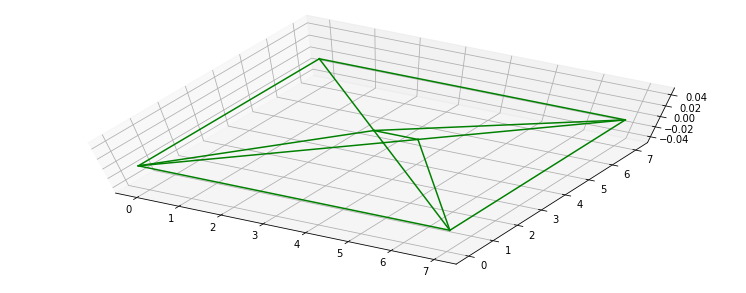

In [24]:
G3.draw('green')

In [25]:
pr=G3.nn_input()

In [26]:
pr[-1],pr[-2]

(-6.337540351289916e-05, 63.79898987322332)

In [27]:
# G3.add_node()
# G3.add_node()
# G3.add_node()
# G3.add_node()
# G3.add_node()
# G3.add_node()
# G3.add_node()
# G3.add_node()

INFO:tensorflow:Restoring parameters from ./policy11/pinjointed11.ckpt
0
-6.336467946681583e-05
0
-5.132449913592278e-05
0
-5.1091590775081e-05
0
-5.0788789426222514e-05
0
-5.078848212350519e-05
0
-5.071329820317819e-05
3
-5.070943845424897e-05
3
-5.1457785309497754e-05
0
-5.141878194722518e-05
3
-5.141895271164506e-05
3
-5.141573814136793e-05
3
-5.141584638970229e-05
3
-5.141609633013842e-05
3
-5.141341256647128e-05
3
-5.154811525701697e-05
3
-5.299526098831735e-05
3
-5.0439417349465665e-05
3
-5.3005595164471104e-05
3
-5.3000797002312306e-05
3
-5.299603753473121e-05
3
-4.9311461971954305e-05
3
-4.991297358111392e-05
3
-5.044647777624874e-05
3
-5.0443351807269194e-05
3
-5.043978617818068e-05
3
-4.959554516318641e-05
3
-4.959239304167386e-05
3
-4.95893240256822e-05
3
-4.958949254386273e-05
3
-4.958596207739216e-05
3
-4.958607320555143e-05
3
-4.9586219602773624e-05
3
-4.958630944597929e-05
3
-4.9586347236785775e-05
3
-4.9583452147021215e-05
3
-4.958011335818321e-05
3
-5.1569437656932126e

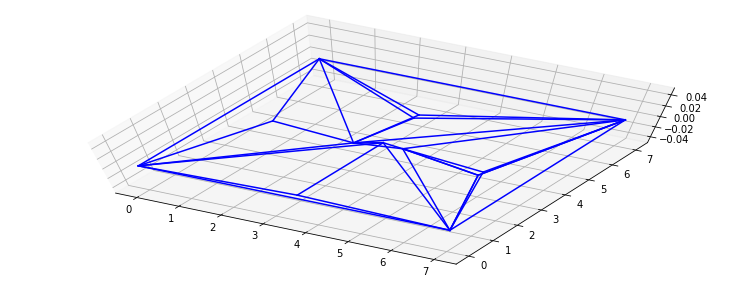

(-5.2523215437755016e-05, 131.44076755260153)

In [28]:
predict(G3)